# Vamos a leer el cluster 3 y generar una predicción basado en los trabajos de Diana

vamos por paso
Vamos a ver si por memoria tengo que partir

En este caso no voy a generar las covariables que generó Daiana

Voy a probar que corra, si corre luego le agrego las variables y veo los cambios en Kaggle

Vamos a ver con CPU y llegado el caso pruebo con GPU




## Preparo todo

In [1]:
### me preparo en el entorno
# entorno
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    #FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    #DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    FUENTES_DIR = '/content/drive/MyDrive/MCD/Labo3/FUENTES/' # Ajustar según usuario
    DATOS_DIR = '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/' # ajustar según usuario OJO crear un acceso directo para poder "montar" una unidad compartida
else:
    # configuración para notebook con instalación LOCAL
    # FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = './DATOS/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


In [2]:
## Cargo lo necesario
# Cargo paquetes
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from numpy.polynomial import Polynomial
#from scipy.signal import detrend

#import itertools

import gc
from datetime import datetime

#import holidays

#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')

In [3]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import KFold # Use KFold for regression
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from lightgbm import early_stopping
import matplotlib.pyplot as plt
import os




In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 9.0 MB/s eta 0:00:00


In [5]:
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

## Levanto el dataset
vamos a hacer el promedio de los últimos 12 meses por producto

In [6]:
# me traigo el archivo ya procesado con la duración completa
df_cluster_3 = pd.read_parquet(DATOS_DIR +'df_cluster3_full.parquet')
#df_cluster_3.head()
# productos a validar Son los que se van a estar vivos
productos_validar = pd.read_csv(DATOS_DIR +'product_id_apredecir201912.txt', sep='\t')
# me traigo el clasificador de clusters


In [7]:
# me quedo con las filas de df_cluster_3 cuyo product_id esté en productos_validar
###################################################
##### OJO, en realidad debo dejar todo
##### dejo las otras series que ayuden
##### saco de todo el conjunto lo que necesito al final
#############################
#df_cluster_X = df_cluster_3[df_cluster_3['product_id'].isin(productos_validar['product_id'])]
df_cluster_X = df_cluster_3.copy()
df_cluster_X.shape

(174785, 332)

In [8]:
## A partir de df_cluster_X quiero generar un df_historia que tenga indice, primera columna produc_cust_id segunda columna el mínimo valor distinto de cero para dicho product_cust_id
# Filtra las filas donde tn es distinto de cero
df_filtrado = df_cluster_X[df_cluster_X['tn'] != 0]

# Agrupa por product_cust_id y calcula el mínimo de tn (distinto de cero)
df_historia = (
    df_filtrado
    .groupby('product_cust_id', as_index=False)['tn']
    .min()
    .rename(columns={'tn': 'min'})
)

print(df_historia.head())

  product_cust_id     min
0     20001_10003   1.848
1     20001_10007  28.934
2     20001_10013  16.019
3     20001_10040   0.123
4     20001_10053   0.056


## comenzamos con LGBM

tomo las ideas y valores de DI

La estructura de Chat

Y cruzo los dedos


In [9]:
# Ordenar por product_cus_id y mes
df_cluster_X = df_cluster_X.sort_values(['product_cust_id', 'date_mes']).copy()

# Crear columna tn desplazada 2 meses adelante (tn_{t+2})
df_cluster_X['tn_shifted'] = (
    df_cluster_X.groupby('product_cust_id')['tn']
    .shift(-2)
)

# Crear target = tn_{t+2} - tn_{t}
df_cluster_X['target_diff'] = df_cluster_X['tn_shifted'] - df_cluster_X['tn']

In [10]:
# Crear columna 'pc_id' como producto de product_id * customer_id (int64)
df_cluster_X['pc_id'] = df_cluster_X['product_id'] * df_cluster_X['customer_id']

# Crear columna 'p_id' convirtiendo product_id a string
df_cluster_X['p_id'] = df_cluster_X['product_id'].astype(str)

# Crear columna 'c_id' convirtiendo customer_id a string
df_cluster_X['c_id'] = df_cluster_X['customer_id'].astype(str)

In [11]:
# Filtrar filas donde target_diff existe (meses 1 a 34)
df_model = df_cluster_X[df_cluster_X['target_diff'].notnull()].copy()

In [ ]:
df_model.shape

(162269, 337)

In [12]:
# me guardo copia del modelo, por las dudas
df_model_backup = df_model.copy()

In [13]:
# ----- Paso 1: Definir columnas -----

# Variables categóricas (tipo object o category), excluyendo product_cus_id
categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
if 'product_cust_id' in categorical_cols:
    categorical_cols.remove('product_cust_id')
if 'p_id' in categorical_cols:
    categorical_cols.remove('p_id')
if 'c_id' in categorical_cols:
    categorical_cols.remove('c_id')


# Variable objetivo e IDs a excluir de features
exclude_cols = ['target_diff', 'tn', 'tn_shifted', 'product_cust_id', 'date_mes']

# Variables numéricas (excluyendo categóricas y columnas a excluir)
num_cols = [
    c for c in df_model.columns
    if c not in categorical_cols + exclude_cols and np.issubdtype(df_model[c].dtype, np.number)
]

In [14]:
scalers = {}

for col in num_cols:
    col_data = df_model[col]
    std = col_data.std()
    mean = col_data.mean()

    if std > 0:
        df_model[col] = col_data / std
        scalers[col] = ('std', std)
    elif mean > 0:
        df_model[col] = col_data / mean
        scalers[col] = ('mean', mean)
    else:
        # No se escala si std=0 y mean=0
        scalers[col] = ('none', None)

In [15]:
## dejo por si hace falta luego escalar por serie: OJO menos valores más inestable. pero captura mejor los detalles
def normalize_group(df, cols):
    df_norm = df.copy()
    for col in cols:
        def scale_func(x):
            std = x.std()
            mean = x.mean()
            if std > 0:
                return x / std
            elif mean > 0:
                return x / mean
            else:
                return x
        df_norm[col] = df.groupby('product_cus_id')[col].transform(scale_func)
    return df_norm

#df_model_norm = normalize_group(df_model, num_cols)

In [16]:
# ----- Paso 3: Label Encoding para categóricas -----

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    vals = df_model[col].astype(str).fillna('missing')
    df_model[col] = le.fit_transform(vals)
    le_dict[col] = le

In [17]:
df_model.head()

,customer_id,product_id,date_mes,first_customer_date,last_customer_date,first_product_date,last_product_date,tn,dif_tn,dif_por,vida_prod,vida_customer,meses_on,meses_off,vida_restante,anio,mes,secuencia,trimestre,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,periodo,stock_final,dias_laborables_arg,cisne_negro,VtaGral,VtaGralCte,Bebidas,Almacen,Panaderia,Lacteos,Carnes,Verduleria_y_fruteria,Articulos_de_limpieza_y_perfumeria,Indumentaria_calzado_y_textiles_para_el_hogar,Electronicos_y_articulos_para_el_hogar,Otros,USD_of,USD_blue,Infl,Expect,product_cust_id,tn_sum_cus,tn_sum_cus_rolling_3m,tn_sum_cus_rolling_3m_min,tn_sum_cus_rolling_3m_max,tn_sum_cus_rolling_3m_std,tn_sum_cus_rolling_6m,tn_sum_cus_rolling_6m_min,tn_sum_cus_rolling_6m_max,tn_sum_cus_rolling_6m_std,tn_sum_cus_rolling_9m,tn_sum_cus_rolling_9m_min,tn_sum_cus_rolling_9m_max,tn_sum_cus_rolling_9m_std,tn_sum_cus_rolling_12m,tn_sum_cus_rolling_12m_min,tn_sum_cus_rolling_12m_max,tn_sum_cus_rolling_12m_std,tn_sum_cus_lag_3m,tn_sum_cus_lag_3m_min,tn_sum_cus_lag_3m_max,tn_sum_cus_lag_3m_std,tn_sum_cus_lag_6m,tn_sum_cus_lag_6m_min,tn_sum_cus_lag_6m_max,tn_sum_cus_lag_6m_std,tn_sum_cus_lag_9m,tn_sum_cus_lag_9m_min,tn_sum_cus_lag_9m_max,tn_sum_cus_lag_9m_std,tn_sum_cus_lag_12m,tn_sum_cus_lag_12m_min,tn_sum_cus_lag_12m_max,tn_sum_cus_lag_12m_std,delta_rolling_3m,delta_rolling_3m_min,delta_rolling_3m_max,delta_rolling_3m_std,delta_rolling_6m,delta_rolling_6m_min,delta_rolling_6m_max,delta_rolling_6m_std,delta_rolling_9m,delta_rolling_9m_min,delta_rolling_9m_max,delta_rolling_9m_std,delta_rolling_12m,delta_rolling_12m_min,delta_rolling_12m_max,delta_rolling_12m_std,delta_lag_3m,delta_lag_3m_min,delta_lag_3m_max,delta_lag_3m_std,delta_lag_6m,delta_lag_6m_min,delta_lag_6m_max,delta_lag_6m_std,delta_lag_9m,delta_lag_9m_min,delta_lag_9m_max,delta_lag_9m_std,delta_lag_12m,delta_lag_12m_min,delta_lag_12m_max,delta_lag_12m_std,tn_sum_cus_min,tn_sum_cus_max,tn_sum_cus_std,tn_sum_prod,tn_sum_prod_rolling_3m,tn_sum_prod_rolling_3m_min,tn_sum_prod_rolling_3m_max,tn_sum_prod_rolling_3m_std,tn_sum_prod_rolling_6m,tn_sum_prod_rolling_6m_min,tn_sum_prod_rolling_6m_max,tn_sum_prod_rolling_6m_std,tn_sum_prod_rolling_9m,tn_sum_prod_rolling_9m_min,tn_sum_prod_rolling_9m_max,tn_sum_prod_rolling_9m_std,tn_sum_prod_rolling_12m,tn_sum_prod_rolling_12m_min,tn_sum_prod_rolling_12m_max,tn_sum_prod_rolling_12m_std,tn_sum_prod_lag_3m,tn_sum_prod_lag_3m_min,tn_sum_prod_lag_3m_max,tn_sum_prod_lag_3m_std,tn_sum_prod_lag_6m,tn_sum_prod_lag_6m_min,tn_sum_prod_lag_6m_max,tn_sum_prod_lag_6m_std,tn_sum_prod_lag_9m,tn_sum_prod_lag_9m_min,tn_sum_prod_lag_9m_max,tn_sum_prod_lag_9m_std,tn_sum_prod_lag_12m,tn_sum_prod_lag_12m_min,tn_sum_prod_lag_12m_max,tn_sum_prod_lag_12m_std,delta_rolling_3m_prod,delta_rolling_3m_min_prod,delta_rolling_3m_max_prod,delta_rolling_3m_std_prod,delta_rolling_6m_prod,delta_rolling_6m_min_prod,delta_rolling_6m_max_prod,delta_rolling_6m_std_prod,delta_rolling_9m_prod,delta_rolling_9m_min_prod,delta_rolling_9m_max_prod,delta_rolling_9m_std_prod,delta_rolling_12m_prod,delta_rolling_12m_min_prod,delta_rolling_12m_max_prod,delta_rolling_12m_std_prod,delta_lag_3m_prod,delta_lag_3m_min_prod,delta_lag_3m_max_prod,delta_lag_3m_std_prod,delta_lag_6m_prod,delta_lag_6m_min_prod,delta_lag_6m_max_prod,delta_lag_6m_std_prod,delta_lag_9m_prod,delta_lag_9m_min_prod,delta_lag_9m_max_prod,delta_lag_9m_std_prod,delta_lag_12m_prod,delta_lag_12m_min_prod,delta_lag_12m_max_prod,delta_lag_12m_std_prod,tn_sum_prod_min,tn_sum_prod_max,tn_sum_prod_std,tn_lag1,tn_lag2,tn_lag3,tn_lag4,tn_lag5,tn_lag6,tn_lag7,tn_lag8,tn_lag9,tn_lag10,tn_lag11,tn_lag12,tn_mean_3m,tn_min_3m,tn_max_3m,tn_std_3m,tn_trend_3m,tn_meses_desde_max_3m,tn_mean_6m,tn_min_6m,tn_max_6m,tn_std_6m,tn_trend_6m,tn_meses_desde_max_6m,tn_mean_9m,tn_min_9m,tn_max_9m,tn_std_9m,tn_trend_9m,tn_meses_desde_max_9m,tn_mean_12m,tn_min_12m,tn_max_12m,tn_std_12m,tn_trend_12m,tn_meses_desde_max_12m,tn_cat1_cus_mes,tn_cat1_cat2_cus_mes,

In [18]:
# ----- Paso 4: Prep X, y -----

X = df_model[num_cols + categorical_cols]
y = df_model['target_diff'].values


In [19]:
# ----- Paso 5: Función objetivo Optuna con 5-Fold CV -----

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mse', # dejo MSE por el problema
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'num_leaves': trial.suggest_int('num_leaves', 10, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 40, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols, free_raw_data=False)
        lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train, categorical_feature=categorical_cols, free_raw_data=False)
        gbm = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=1000,
            callbacks=[early_stopping(stopping_rounds=50)],
            #verbose_eval=False
        )
        preds = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        mse = mean_squared_error(y_val, preds)
        rmse = np.sqrt(mse)
        rmses.append(rmse)

    return np.mean(rmses)

In [ ]:
# si tengo los resultados de una corrida anterior, no corro esta celda.
#################
## Falta automatizar más
#################
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Mejor RMSE promedio en CV: {study.best_value:.6f}')
print(f'Mejor parámetros: {study.best_params}')

[I 2025-07-20 05:09:07,126] A new study created in memory with name: no-name-219be77d-1a5f-47cb-a9e6-6ddfc1c9f434
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-81-1598291573.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uni

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[201]	valid_0's l2: 15.4743
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's l2: 17.7976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	valid_0's l2: 10.5298
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	valid_0's l2: 12.0837
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:09:57,780] Trial 0 finished with value: 3.7151640450850243 and parameters: {'num_leaves': 138, 'max_depth': 6, 'learning_rate': 0.05947180360125079, 'feature_fraction': 0.9291019069103952, 'bagging_fraction': 0.8340628749764134, 'bagging_freq': 7, 'min_data_in_leaf': 55, 'lambda_l1': 7.737867737849242, 'lambda_l2': 1.4770138340574966e-07}. Best is trial 0 with value: 3.7151640450850243.


Early stopping, best iteration is:
[203]	valid_0's l2: 13.7066


/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-81-1598291573.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid_0's l2: 15.6079
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 17.6376
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[282]	valid_0's l2: 10.0959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[241]	valid_0's l2: 12.1076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's l2: 13.8442


[I 2025-07-20 05:11:10,866] Trial 1 finished with value: 3.7056355432213217 and parameters: {'num_leaves': 111, 'max_depth': 11, 'learning_rate': 0.07119133110685592, 'feature_fraction': 0.9718822972986472, 'bagging_fraction': 0.7648408835847541, 'bagging_freq': 3, 'min_data_in_leaf': 86, 'lambda_l1': 2.2862011212368235e-05, 'lambda_l2': 5.399694524059453e-06}. Best is trial 1 with value: 3.7056355432213217.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	valid_0's l2: 16.0571
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 18.0932
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[255]	valid_0's l2: 10.3638
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 11.7151
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's l2: 13.6835


[I 2025-07-20 05:11:51,449] Trial 2 finished with value: 3.720377356911237 and parameters: {'num_leaves': 225, 'max_depth': 4, 'learning_rate': 0.16585604147944946, 'feature_fraction': 0.6555816130469432, 'bagging_fraction': 0.9293336694666641, 'bagging_freq': 6, 'min_data_in_leaf': 75, 'lambda_l1': 0.08352607234533935, 'lambda_l2': 0.0007440018503260525}. Best is trial 1 with value: 3.7056355432213217.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[847]	valid_0's l2: 15.4177
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's l2: 17.673
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[748]	valid_0's l2: 10.0534
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[541]	valid_0's l2: 11.7446
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[660]	valid_0's l2: 13.8534


[I 2025-07-20 05:13:53,081] Trial 3 finished with value: 3.6900451778260477 and parameters: {'num_leaves': 143, 'max_depth': 5, 'learning_rate': 0.025903530315571674, 'feature_fraction': 0.5985798880884254, 'bagging_fraction': 0.9817327122178581, 'bagging_freq': 7, 'min_data_in_leaf': 88, 'lambda_l1': 1.6531791762343043e-07, 'lambda_l2': 3.24341053296774}. Best is trial 3 with value: 3.6900451778260477.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's l2: 16.2776
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's l2: 18.3997
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's l2: 10.1256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	valid_0's l2: 12.6899
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:14:31,756] Trial 4 finished with value: 3.7746224932673136 and parameters: {'num_leaves': 238, 'max_depth': 5, 'learning_rate': 0.17046235799975037, 'feature_fraction': 0.9636440870208951, 'bagging_fraction': 0.6751125967232695, 'bagging_freq': 3, 'min_data_in_leaf': 92, 'lambda_l1': 4.824415198541062e-05, 'lambda_l2': 4.888059549271931}. Best is trial 3 with value: 3.6900451778260477.


Early stopping, best iteration is:
[123]	valid_0's l2: 14.4759


/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-81-1598291573.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[954]	valid_0's l2: 15.8397
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's l2: 18.1546
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's l2: 10.4536
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[804]	valid_0's l2: 11.8861
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[628]	valid_0's l2: 13.6094


[I 2025-07-20 05:16:11,595] Trial 5 finished with value: 3.7221307945558264 and parameters: {'num_leaves': 251, 'max_depth': 3, 'learning_rate': 0.014671060300337603, 'feature_fraction': 0.7278529905367097, 'bagging_fraction': 0.854118885727498, 'bagging_freq': 4, 'min_data_in_leaf': 53, 'lambda_l1': 0.0023251694384590505, 'lambda_l2': 0.001759961408700312}. Best is trial 3 with value: 3.6900451778260477.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 15.7409
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 17.7889
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[188]	valid_0's l2: 10.4827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's l2: 12.3004
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's l2: 13.8357


[I 2025-07-20 05:17:15,456] Trial 6 finished with value: 3.729941827155657 and parameters: {'num_leaves': 43, 'max_depth': 17, 'learning_rate': 0.12640071927841798, 'feature_fraction': 0.9913894126904995, 'bagging_fraction': 0.7413311963732054, 'bagging_freq': 2, 'min_data_in_leaf': 80, 'lambda_l1': 0.011817935298359847, 'lambda_l2': 0.010872809170339325}. Best is trial 3 with value: 3.6900451778260477.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[294]	valid_0's l2: 16.4476
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's l2: 17.9363
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[469]	valid_0's l2: 10.4651
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[343]	valid_0's l2: 12.0988
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	valid_0's l2: 14.2142


[I 2025-07-20 05:18:15,515] Trial 7 finished with value: 3.754836028783626 and parameters: {'num_leaves': 134, 'max_depth': 4, 'learning_rate': 0.03321086995140082, 'feature_fraction': 0.7143032288577777, 'bagging_fraction': 0.7733975303444318, 'bagging_freq': 7, 'min_data_in_leaf': 78, 'lambda_l1': 0.022701483092967937, 'lambda_l2': 0.9607804498202428}. Best is trial 3 with value: 3.6900451778260477.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('featu

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[834]	valid_0's l2: 15.9564
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[350]	valid_0's l2: 17.5015
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[734]	valid_0's l2: 10.6588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[752]	valid_0's l2: 11.8588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[944]	valid_0's l2: 13.8501


[I 2025-07-20 05:21:39,521] Trial 8 finished with value: 3.7216083225469228 and parameters: {'num_leaves': 34, 'max_depth': 16, 'learning_rate': 0.011958292749559615, 'feature_fraction': 0.8185180831092065, 'bagging_fraction': 0.8715811574290151, 'bagging_freq': 2, 'min_data_in_leaf': 82, 'lambda_l1': 1.9674317032180037e-05, 'lambda_l2': 2.188649773220976}. Best is trial 3 with value: 3.6900451778260477.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[630]	valid_0's l2: 15.4725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[348]	valid_0's l2: 17.5058
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[378]	valid_0's l2: 10.7355
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[372]	valid_0's l2: 12.0504
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[372]	valid_0's l2: 13.8726


[I 2025-07-20 05:23:27,698] Trial 9 finished with value: 3.717994695145412 and parameters: {'num_leaves': 196, 'max_depth': 9, 'learning_rate': 0.020465510506270643, 'feature_fraction': 0.8513477263093555, 'bagging_fraction': 0.8124289007306795, 'bagging_freq': 6, 'min_data_in_leaf': 73, 'lambda_l1': 5.719873759358331e-08, 'lambda_l2': 0.0027034883890802008}. Best is trial 3 with value: 3.6900451778260477.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[505]	valid_0's l2: 15.6376
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	valid_0's l2: 17.2151
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[254]	valid_0's l2: 10.4464
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[265]	valid_0's l2: 11.7184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[555]	valid_0's l2: 13.646


[I 2025-07-20 05:25:05,698] Trial 10 finished with value: 3.6905835046284614 and parameters: {'num_leaves': 181, 'max_depth': 14, 'learning_rate': 0.031665951499618566, 'feature_fraction': 0.502224503927041, 'bagging_fraction': 0.9827102822052107, 'bagging_freq': 5, 'min_data_in_leaf': 99, 'lambda_l1': 5.692523126322115e-08, 'lambda_l2': 1.097519185031053e-05}. Best is trial 3 with value: 3.6900451778260477.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[470]	valid_0's l2: 16.0327
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's l2: 17.3764
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[267]	valid_0's l2: 10.4444
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[346]	valid_0's l2: 11.7619
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[368]	valid_0's l2: 13.7386


[I 2025-07-20 05:26:37,114] Trial 11 finished with value: 3.7080997086003933 and parameters: {'num_leaves': 175, 'max_depth': 14, 'learning_rate': 0.03088468490206251, 'feature_fraction': 0.5006584211076056, 'bagging_fraction': 0.9963382838917715, 'bagging_freq': 5, 'min_data_in_leaf': 99, 'lambda_l1': 1.2823919326188469e-08, 'lambda_l2': 6.77609565253474e-06}. Best is trial 3 with value: 3.6900451778260477.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[672]	valid_0's l2: 15.809
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's l2: 17.2642
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[440]	valid_0's l2: 10.3691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[310]	valid_0's l2: 11.7888
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[477]	valid_0's l2: 13.7382


[I 2025-07-20 05:29:06,249] Trial 12 finished with value: 3.698234235806082 and parameters: {'num_leaves': 91, 'max_depth': 19, 'learning_rate': 0.02253279269942069, 'feature_fraction': 0.5086715930145105, 'bagging_fraction': 0.9938064724690522, 'bagging_freq': 5, 'min_data_in_leaf': 98, 'lambda_l1': 2.978014654760464e-07, 'lambda_l2': 5.18942188773902e-06}. Best is trial 3 with value: 3.6900451778260477.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[529]	valid_0's l2: 15.2094
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's l2: 17.4274
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's l2: 10.3161
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's l2: 11.5675
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's l2: 13.6149


[I 2025-07-20 05:30:21,557] Trial 13 finished with value: 3.675469464355318 and parameters: {'num_leaves': 169, 'max_depth': 9, 'learning_rate': 0.04350749319585471, 'feature_fraction': 0.5893876857252325, 'bagging_fraction': 0.9193812030514172, 'bagging_freq': 6, 'min_data_in_leaf': 63, 'lambda_l1': 1.4491154913057033e-06, 'lambda_l2': 1.5186782930368696e-08}. Best is trial 13 with value: 3.675469464355318.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[405]	valid_0's l2: 15.4735
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 17.4451
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's l2: 10.3473
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's l2: 11.7227
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:31:16,134] Trial 14 finished with value: 3.68729158191307 and parameters: {'num_leaves': 155, 'max_depth': 8, 'learning_rate': 0.056559238138013855, 'feature_fraction': 0.6360284113014275, 'bagging_fraction': 0.9170111357904698, 'bagging_freq': 7, 'min_data_in_leaf': 63, 'lambda_l1': 1.294496015422056e-06, 'lambda_l2': 2.474434504856856e-08}. Best is trial 13 with value: 3.675469464355318.


Early stopping, best iteration is:
[147]	valid_0's l2: 13.5831


/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-81-1598291573.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	valid_0's l2: 14.9451
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's l2: 17.6726
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	valid_0's l2: 10.1926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's l2: 12.1383
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:31:57,199] Trial 15 finished with value: 3.7080048635475458 and parameters: {'num_leaves': 79, 'max_depth': 8, 'learning_rate': 0.08440890595940842, 'feature_fraction': 0.6080056257914868, 'bagging_fraction': 0.911257876181684, 'bagging_freq': 6, 'min_data_in_leaf': 40, 'lambda_l1': 2.3251509153952308e-06, 'lambda_l2': 1.0280830875073855e-08}. Best is trial 13 with value: 3.675469464355318.


Early stopping, best iteration is:
[46]	valid_0's l2: 14.3918


/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-81-1598291573.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[191]	valid_0's l2: 15.3779
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 17.4539
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[214]	valid_0's l2: 10.4051
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's l2: 11.6225
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:32:54,682] Trial 16 finished with value: 3.6936451147171567 and parameters: {'num_leaves': 164, 'max_depth': 9, 'learning_rate': 0.04665808425188015, 'feature_fraction': 0.5980400240258706, 'bagging_fraction': 0.9138133470079944, 'bagging_freq': 6, 'min_data_in_leaf': 61, 'lambda_l1': 1.8999774090492612e-06, 'lambda_l2': 1.1545095514099268e-08}. Best is trial 13 with value: 3.675469464355318.


Early stopping, best iteration is:
[149]	valid_0's l2: 13.9435


/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-81-1598291573.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[142]	valid_0's l2: 15.6167
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's l2: 17.1419
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[181]	valid_0's l2: 10.5847
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[223]	valid_0's l2: 11.7662
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[160]	valid_0's l2: 13.9911


[I 2025-07-20 05:34:03,827] Trial 17 finished with value: 3.703231316811886 and parameters: {'num_leaves': 200, 'max_depth': 11, 'learning_rate': 0.04854342568044363, 'feature_fraction': 0.6700618826198225, 'bagging_fraction': 0.9359612922720282, 'bagging_freq': 1, 'min_data_in_leaf': 66, 'lambda_l1': 0.0008548748156139231, 'lambda_l2': 3.112566150054842e-07}. Best is trial 13 with value: 3.675469464355318.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[214]	valid_0's l2: 15.4666
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's l2: 18.0161
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[118]	valid_0's l2: 11.1449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's l2: 12.2054
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:34:44,101] Trial 18 finished with value: 3.75160223034433 and parameters: {'num_leaves': 106, 'max_depth': 7, 'learning_rate': 0.09732829807715679, 'feature_fraction': 0.5638038426228833, 'bagging_fraction': 0.6316801788407701, 'bagging_freq': 7, 'min_data_in_leaf': 44, 'lambda_l1': 1.976549638231018e-06, 'lambda_l2': 2.0504206225045963e-07}. Best is trial 13 with value: 3.675469464355318.


Early stopping, best iteration is:
[107]	valid_0's l2: 14.0527


/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-81-1598291573.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[372]	valid_0's l2: 15.1979
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 17.4687
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid_0's l2: 10.4209
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	valid_0's l2: 11.6119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's l2: 13.7749


[I 2025-07-20 05:36:15,409] Trial 19 finished with value: 3.6850444990684847 and parameters: {'num_leaves': 216, 'max_depth': 13, 'learning_rate': 0.03893971327864254, 'feature_fraction': 0.7894558924605755, 'bagging_fraction': 0.8664117593700451, 'bagging_freq': 4, 'min_data_in_leaf': 65, 'lambda_l1': 5.09422148705725e-05, 'lambda_l2': 7.484238133840122e-05}. Best is trial 13 with value: 3.675469464355318.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[372]	valid_0's l2: 15.038
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's l2: 17.4377
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[237]	valid_0's l2: 10.3282
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	valid_0's l2: 11.9353
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's l2: 13.8084


[I 2025-07-20 05:37:55,723] Trial 20 finished with value: 3.687644243557113 and parameters: {'num_leaves': 215, 'max_depth': 13, 'learning_rate': 0.03742054851182385, 'feature_fraction': 0.7998505392598948, 'bagging_fraction': 0.8763429301355048, 'bagging_freq': 4, 'min_data_in_leaf': 55, 'lambda_l1': 8.319559376283338e-05, 'lambda_l2': 0.1080223273873851}. Best is trial 13 with value: 3.675469464355318.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's l2: 15.2917
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's l2: 17.2632
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	valid_0's l2: 10.1588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	valid_0's l2: 11.6636
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:38:58,546] Trial 21 finished with value: 3.683103249186707 and parameters: {'num_leaves': 157, 'max_depth': 12, 'learning_rate': 0.06210088334235274, 'feature_fraction': 0.776886450908163, 'bagging_fraction': 0.9048037665521069, 'bagging_freq': 4, 'min_data_in_leaf': 66, 'lambda_l1': 6.748981192632411e-06, 'lambda_l2': 0.00011618855848592615}. Best is trial 13 with value: 3.675469464355318.


Early stopping, best iteration is:
[127]	valid_0's l2: 14.045


/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-81-1598291573.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[418]	valid_0's l2: 15.246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's l2: 17.427
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[282]	valid_0's l2: 10.2512
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[272]	valid_0's l2: 11.7825
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[218]	valid_0's l2: 13.5816


[I 2025-07-20 05:40:40,429] Trial 22 finished with value: 3.6797633001398617 and parameters: {'num_leaves': 192, 'max_depth': 12, 'learning_rate': 0.04152039814415411, 'feature_fraction': 0.7749744298579462, 'bagging_fraction': 0.8743916261884238, 'bagging_freq': 3, 'min_data_in_leaf': 69, 'lambda_l1': 0.00020515220533731354, 'lambda_l2': 8.291690178256483e-05}. Best is trial 13 with value: 3.675469464355318.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's l2: 15.9019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 17.5876
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's l2: 10.6055
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	valid_0's l2: 11.9723
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:41:33,165] Trial 23 finished with value: 3.7371062110228737 and parameters: {'num_leaves': 184, 'max_depth': 10, 'learning_rate': 0.07374621040709434, 'feature_fraction': 0.8754283767805298, 'bagging_fraction': 0.8940269900140803, 'bagging_freq': 3, 'min_data_in_leaf': 70, 'lambda_l1': 0.0005309163018423141, 'lambda_l2': 4.41219044314517e-05}. Best is trial 13 with value: 3.675469464355318.


Early stopping, best iteration is:
[143]	valid_0's l2: 14.3441


/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-81-1598291573.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's l2: 15.7847
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's l2: 17.5433
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's l2: 10.3585
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's l2: 11.6904
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:42:24,319] Trial 24 finished with value: 3.7101165389739563 and parameters: {'num_leaves': 159, 'max_depth': 12, 'learning_rate': 0.1055674737367511, 'feature_fraction': 0.7706677400128216, 'bagging_fraction': 0.8390589822613803, 'bagging_freq': 2, 'min_data_in_leaf': 59, 'lambda_l1': 5.316966122583411e-06, 'lambda_l2': 0.02582110040841687}. Best is trial 13 with value: 3.675469464355318.


Early stopping, best iteration is:
[92]	valid_0's l2: 14.0739


/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-81-1598291573.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[176]	valid_0's l2: 15.683
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 17.2151
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 10.4509
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[161]	valid_0's l2: 11.5571
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's l2: 13.9114


[I 2025-07-20 05:43:42,532] Trial 25 finished with value: 3.6942875765696543 and parameters: {'num_leaves': 125, 'max_depth': 16, 'learning_rate': 0.05913764368093107, 'feature_fraction': 0.7524216182287551, 'bagging_fraction': 0.9639040011536011, 'bagging_freq': 4, 'min_data_in_leaf': 68, 'lambda_l1': 0.0001618696561510332, 'lambda_l2': 0.00018224877638238723}. Best is trial 13 with value: 3.675469464355318.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[288]	valid_0's l2: 14.948
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's l2: 17.5063
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[181]	valid_0's l2: 10.4707
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	valid_0's l2: 11.6075
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	valid_0's l2: 13.6607


[I 2025-07-20 05:44:55,458] Trial 26 finished with value: 3.677836507008812 and parameters: {'num_leaves': 199, 'max_depth': 10, 'learning_rate': 0.047034251337796554, 'feature_fraction': 0.698158713718969, 'bagging_fraction': 0.9510235647170218, 'bagging_freq': 3, 'min_data_in_leaf': 51, 'lambda_l1': 1.0461797651581118e-05, 'lambda_l2': 7.688101998931836e-07}. Best is trial 13 with value: 3.675469464355318.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[307]	valid_0's l2: 15.2318
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[119]	valid_0's l2: 17.4519
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[176]	valid_0's l2: 10.4888
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's l2: 11.3037
Training until validation scores don't improve for 50 rounds


[I 2025-07-20 05:45:58,868] Trial 27 finished with value: 3.6710108044959155 and parameters: {'num_leaves': 196, 'max_depth': 10, 'learning_rate': 0.045554441136149704, 'feature_fraction': 0.699977695864299, 'bagging_fraction': 0.9454058706407127, 'bagging_freq': 1, 'min_data_in_leaf': 49, 'lambda_l1': 4.776479518698254e-07, 'lambda_l2': 4.5616824129055476e-07}. Best is trial 27 with value: 3.6710108044959155.


Early stopping, best iteration is:
[139]	valid_0's l2: 13.4981


/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-81-1598291573.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[643]	valid_0's l2: 14.9752
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	valid_0's l2: 17.5823
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[487]	valid_0's l2: 10.3674
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[381]	valid_0's l2: 11.6276
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[331]	valid_0's l2: 13.5519


[I 2025-07-20 05:47:46,180] Trial 28 finished with value: 3.6747911420248216 and parameters: {'num_leaves': 209, 'max_depth': 9, 'learning_rate': 0.018569616859327374, 'feature_fraction': 0.6838051843943482, 'bagging_fraction': 0.9551614243751797, 'bagging_freq': 1, 'min_data_in_leaf': 49, 'lambda_l1': 5.438357933631331e-07, 'lambda_l2': 7.638797985601832e-07}. Best is trial 27 with value: 3.6710108044959155.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 14.9122
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's l2: 17.8341
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[957]	valid_0's l2: 10.2351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[605]	valid_0's l2: 11.8028
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[685]	valid_0's l2: 13.6593


[I 2025-07-20 05:50:02,863] Trial 29 finished with value: 3.683057986340091 and parameters: {'num_leaves': 254, 'max_depth': 7, 'learning_rate': 0.010323411039884815, 'feature_fraction': 0.6797333331138894, 'bagging_fraction': 0.9495891562817819, 'bagging_freq': 1, 'min_data_in_leaf': 48, 'lambda_l1': 1.1296859384677776e-08, 'lambda_l2': 5.423087872205446e-08}. Best is trial 27 with value: 3.6710108044959155.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[778]	valid_0's l2: 15.2066
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[223]	valid_0's l2: 17.4739
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[537]	valid_0's l2: 10.3424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[350]	valid_0's l2: 11.8665
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[352]	valid_0's l2: 13.7305


[I 2025-07-20 05:51:23,667] Trial 30 finished with value: 3.689192193434419 and parameters: {'num_leaves': 230, 'max_depth': 6, 'learning_rate': 0.01786274615476511, 'feature_fraction': 0.6263957583571017, 'bagging_fraction': 0.802026849299704, 'bagging_freq': 1, 'min_data_in_leaf': 47, 'lambda_l1': 4.234575408742413e-07, 'lambda_l2': 1.05264837435121e-06}. Best is trial 27 with value: 3.6710108044959155.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[397]	valid_0's l2: 14.9992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	valid_0's l2: 17.5419
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's l2: 10.4133
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[348]	valid_0's l2: 11.643
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	valid_0's l2: 13.5058


[I 2025-07-20 05:52:56,287] Trial 31 finished with value: 3.6750720032500097 and parameters: {'num_leaves': 205, 'max_depth': 10, 'learning_rate': 0.025881934358019606, 'feature_fraction': 0.713611800768735, 'bagging_fraction': 0.9557630785243775, 'bagging_freq': 2, 'min_data_in_leaf': 51, 'lambda_l1': 0.8569702615833357, 'lambda_l2': 8.826334199853388e-07}. Best is trial 27 with value: 3.6710108044959155.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[491]	valid_0's l2: 14.7826
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's l2: 17.3549
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[381]	valid_0's l2: 10.2421
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's l2: 11.4986
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[245]	valid_0's l2: 13.696


[I 2025-07-20 05:54:20,882] Trial 32 finished with value: 3.660566741091005 and parameters: {'num_leaves': 212, 'max_depth': 10, 'learning_rate': 0.025134749959361522, 'feature_fraction': 0.5515595148593281, 'bagging_fraction': 0.9640382828850887, 'bagging_freq': 1, 'min_data_in_leaf': 55, 'lambda_l1': 3.912217066155454, 'lambda_l2': 7.641800730902559e-08}. Best is trial 32 with value: 3.660566741091005.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[538]	valid_0's l2: 15.1822
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's l2: 17.3878
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[385]	valid_0's l2: 10.3528
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[427]	valid_0's l2: 11.5264
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[462]	valid_0's l2: 13.7103


[I 2025-07-20 05:56:00,573] Trial 33 finished with value: 3.6763365735617213 and parameters: {'num_leaves': 214, 'max_depth': 10, 'learning_rate': 0.01698969928719435, 'feature_fraction': 0.5651378832582812, 'bagging_fraction': 0.9631894341705328, 'bagging_freq': 1, 'min_data_in_leaf': 56, 'lambda_l1': 4.368388206192877, 'lambda_l2': 8.858174616740667e-07}. Best is trial 32 with value: 3.660566741091005.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[370]	valid_0's l2: 14.8135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's l2: 18.129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[624]	valid_0's l2: 10.1238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid_0's l2: 11.7716
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[256]	valid_0's l2: 13.8604


[I 2025-07-20 05:57:39,747] Trial 34 finished with value: 3.6884721194672307 and parameters: {'num_leaves': 233, 'max_depth': 8, 'learning_rate': 0.02703918813526668, 'feature_fraction': 0.7360462019825436, 'bagging_fraction': 0.9715913845860161, 'bagging_freq': 2, 'min_data_in_leaf': 42, 'lambda_l1': 1.9196136626867157, 'lambda_l2': 8.264908511637161e-08}. Best is trial 32 with value: 3.660566741091005.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[342]	valid_0's l2: 15.1894
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	valid_0's l2: 17.3322
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[335]	valid_0's l2: 10.2966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[334]	valid_0's l2: 11.5972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	valid_0's l2: 13.5326


[I 2025-07-20 05:59:20,828] Trial 35 finished with value: 3.6707039497378147 and parameters: {'num_leaves': 216, 'max_depth': 11, 'learning_rate': 0.024160407659454066, 'feature_fraction': 0.6884394749832772, 'bagging_fraction': 0.944132249829649, 'bagging_freq': 1, 'min_data_in_leaf': 49, 'lambda_l1': 0.6048722472227218, 'lambda_l2': 3.601406291270784e-06}. Best is trial 32 with value: 3.660566741091005.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[752]	valid_0's l2: 14.9753
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's l2: 17.1003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[656]	valid_0's l2: 10.1605
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[503]	valid_0's l2: 11.4553
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's l2: 13.6766


[I 2025-07-20 06:01:33,665] Trial 36 finished with value: 3.655069445436934 and parameters: {'num_leaves': 241, 'max_depth': 11, 'learning_rate': 0.013623372245663372, 'feature_fraction': 0.6474938648997227, 'bagging_fraction': 0.7201678825357821, 'bagging_freq': 1, 'min_data_in_leaf': 46, 'lambda_l1': 0.09404152620315177, 'lambda_l2': 4.063517962584961e-06}. Best is trial 36 with value: 3.655069445436934.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[581]	valid_0's l2: 15.1896
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[187]	valid_0's l2: 17.0776
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[695]	valid_0's l2: 10.0885
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[463]	valid_0's l2: 11.4921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[548]	valid_0's l2: 13.4123


[I 2025-07-20 06:03:28,248] Trial 37 finished with value: 3.651685170215347 and parameters: {'num_leaves': 244, 'max_depth': 11, 'learning_rate': 0.01411913959962108, 'feature_fraction': 0.5384954427769904, 'bagging_fraction': 0.716901523606546, 'bagging_freq': 1, 'min_data_in_leaf': 46, 'lambda_l1': 0.23230185183138113, 'lambda_l2': 1.7236614882368535e-05}. Best is trial 37 with value: 3.651685170215347.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[621]	valid_0's l2: 15.0002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[267]	valid_0's l2: 17.1007
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[594]	valid_0's l2: 10.1819
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[461]	valid_0's l2: 11.4734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[618]	valid_0's l2: 13.1842


[I 2025-07-20 06:06:11,952] Trial 38 finished with value: 3.643492647947909 and parameters: {'num_leaves': 240, 'max_depth': 14, 'learning_rate': 0.013837442026355862, 'feature_fraction': 0.5365015681332908, 'bagging_fraction': 0.7264657872684626, 'bagging_freq': 2, 'min_data_in_leaf': 44, 'lambda_l1': 0.30592987689015, 'lambda_l2': 3.1012514616273163e-06}. Best is trial 38 with value: 3.643492647947909.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[712]	valid_0's l2: 15.0479
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[267]	valid_0's l2: 17.088
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[550]	valid_0's l2: 10.1918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[454]	valid_0's l2: 11.3817
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[615]	valid_0's l2: 13.2602


[I 2025-07-20 06:09:21,000] Trial 39 finished with value: 3.644105202513586 and parameters: {'num_leaves': 242, 'max_depth': 15, 'learning_rate': 0.014078903361719162, 'feature_fraction': 0.5309359985399054, 'bagging_fraction': 0.7258813338027686, 'bagging_freq': 2, 'min_data_in_leaf': 45, 'lambda_l1': 0.11129858600922991, 'lambda_l2': 2.6953984769216795e-05}. Best is trial 38 with value: 3.643492647947909.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[680]	valid_0's l2: 15.0829
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[310]	valid_0's l2: 17.0001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[569]	valid_0's l2: 10.0936
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[461]	valid_0's l2: 11.4754
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[608]	valid_0's l2: 13.2251


[I 2025-07-20 06:12:18,365] Trial 40 finished with value: 3.6415973731287123 and parameters: {'num_leaves': 244, 'max_depth': 15, 'learning_rate': 0.013978146912639829, 'feature_fraction': 0.5381277458263156, 'bagging_fraction': 0.712439724052373, 'bagging_freq': 2, 'min_data_in_leaf': 45, 'lambda_l1': 0.09544329712283663, 'lambda_l2': 2.97614365527624e-05}. Best is trial 40 with value: 3.6415973731287123.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[712]	valid_0's l2: 15.0571
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	valid_0's l2: 16.96
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[562]	valid_0's l2: 10.1017
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[582]	valid_0's l2: 11.4441
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[608]	valid_0's l2: 13.2399


[I 2025-07-20 06:15:29,766] Trial 41 finished with value: 3.639697124449474 and parameters: {'num_leaves': 243, 'max_depth': 16, 'learning_rate': 0.014117586502857323, 'feature_fraction': 0.5341649602696942, 'bagging_fraction': 0.7107706082333125, 'bagging_freq': 2, 'min_data_in_leaf': 45, 'lambda_l1': 0.21380049345119467, 'lambda_l2': 3.054009639524318e-05}. Best is trial 41 with value: 3.639697124449474.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[417]	valid_0's l2: 15.1754
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's l2: 17.0546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[648]	valid_0's l2: 10.0174
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[485]	valid_0's l2: 11.3763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[622]	valid_0's l2: 13.1307


[I 2025-07-20 06:18:31,017] Trial 42 finished with value: 3.6373611418511738 and parameters: {'num_leaves': 243, 'max_depth': 16, 'learning_rate': 0.014913690650371111, 'feature_fraction': 0.5418504059277954, 'bagging_fraction': 0.6985465339763165, 'bagging_freq': 2, 'min_data_in_leaf': 40, 'lambda_l1': 0.14696556645738817, 'lambda_l2': 2.0233207928932984e-05}. Best is trial 42 with value: 3.6373611418511738.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 14.978
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[341]	valid_0's l2: 16.9869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[910]	valid_0's l2: 10.0432
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[768]	valid_0's l2: 11.2424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[748]	valid_0's l2: 13.2916


[I 2025-07-20 06:23:17,676] Trial 43 finished with value: 3.6319023937137245 and parameters: {'num_leaves': 253, 'max_depth': 17, 'learning_rate': 0.010255760672906193, 'feature_fraction': 0.5302889705798297, 'bagging_fraction': 0.6645852522288831, 'bagging_freq': 2, 'min_data_in_leaf': 41, 'lambda_l1': 0.012963125028377865, 'lambda_l2': 0.0003279003956787048}. Best is trial 43 with value: 3.6319023937137245.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[625]	valid_0's l2: 15.075
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's l2: 17.0808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[848]	valid_0's l2: 10.0488
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[570]	valid_0's l2: 11.5271
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[635]	valid_0's l2: 13.3282


[I 2025-07-20 06:27:28,883] Trial 44 finished with value: 3.646294771305321 and parameters: {'num_leaves': 256, 'max_depth': 18, 'learning_rate': 0.01007362066739213, 'feature_fraction': 0.5252297959340589, 'bagging_fraction': 0.6749582066736396, 'bagging_freq': 3, 'min_data_in_leaf': 41, 'lambda_l1': 0.013453344276492668, 'lambda_l2': 0.000541845367501763}. Best is trial 43 with value: 3.6319023937137245.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[712]	valid_0's l2: 15.1231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	valid_0's l2: 17.028
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[447]	valid_0's l2: 10.2796
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[485]	valid_0's l2: 11.4548
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[674]	valid_0's l2: 13.3578


[I 2025-07-20 06:30:55,813] Trial 45 finished with value: 3.652172417679813 and parameters: {'num_leaves': 226, 'max_depth': 17, 'learning_rate': 0.011870746063883763, 'feature_fraction': 0.5788425885647737, 'bagging_fraction': 0.6899901083320278, 'bagging_freq': 2, 'min_data_in_leaf': 43, 'lambda_l1': 0.03329322909696734, 'lambda_l2': 0.00117005075256536}. Best is trial 43 with value: 3.6319023937137245.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[563]	valid_0's l2: 14.9952
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's l2: 17.0722
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[429]	valid_0's l2: 10.1083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[350]	valid_0's l2: 11.4639
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[349]	valid_0's l2: 13.2737


[I 2025-07-20 06:34:17,611] Trial 46 finished with value: 3.6425423293248036 and parameters: {'num_leaves': 247, 'max_depth': 20, 'learning_rate': 0.01603188665313352, 'feature_fraction': 0.5232164793284823, 'bagging_fraction': 0.7679475129543702, 'bagging_freq': 2, 'min_data_in_leaf': 40, 'lambda_l1': 0.0030411010974095245, 'lambda_l2': 0.0026409568204322845}. Best is trial 43 with value: 3.6319023937137245.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[682]	valid_0's l2: 14.9536
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[163]	valid_0's l2: 17.1904
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[569]	valid_0's l2: 10.0793
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[464]	valid_0's l2: 11.4706
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[540]	valid_0's l2: 13.2863


[I 2025-07-20 06:39:42,867] Trial 47 finished with value: 3.643955385922004 and parameters: {'num_leaves': 226, 'max_depth': 20, 'learning_rate': 0.011850033685911645, 'feature_fraction': 0.617651991088706, 'bagging_fraction': 0.764889341412568, 'bagging_freq': 2, 'min_data_in_leaf': 40, 'lambda_l1': 0.0016304455823095078, 'lambda_l2': 0.004203139751288107}. Best is trial 43 with value: 3.6319023937137245.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[630]	valid_0's l2: 15.3182
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	valid_0's l2: 16.8885
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[585]	valid_0's l2: 10.0892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[353]	valid_0's l2: 11.8512
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[492]	valid_0's l2: 13.3691


[I 2025-07-20 06:42:31,488] Trial 48 finished with value: 3.659737294350979 and parameters: {'num_leaves': 249, 'max_depth': 18, 'learning_rate': 0.01620181732180374, 'feature_fraction': 0.5167280147226969, 'bagging_fraction': 0.6381567739506576, 'bagging_freq': 3, 'min_data_in_leaf': 52, 'lambda_l1': 0.004221842613409667, 'lambda_l2': 0.00044347590341672606}. Best is trial 43 with value: 3.6319023937137245.
/tmp/ipython-input-81-1598291573.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-81-1598291573.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[412]	valid_0's l2: 15.2385
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[168]	valid_0's l2: 17.0619
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[520]	valid_0's l2: 10.2013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[400]	valid_0's l2: 11.4636
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	valid_0's l2: 13.1058


[I 2025-07-20 06:44:53,132] Trial 49 finished with value: 3.646840213356243 and parameters: {'num_leaves': 234, 'max_depth': 16, 'learning_rate': 0.019034615449705212, 'feature_fraction': 0.5812368978041756, 'bagging_fraction': 0.6548114297742246, 'bagging_freq': 2, 'min_data_in_leaf': 43, 'lambda_l1': 0.006345867932576323, 'lambda_l2': 0.008992314293514197}. Best is trial 43 with value: 3.6319023937137245.


Mejor RMSE promedio en CV: 3.631902
Mejor parámetros: {'num_leaves': 253, 'max_depth': 17, 'learning_rate': 0.010255760672906193, 'feature_fraction': 0.5302889705798297, 'bagging_fraction': 0.6645852522288831, 'bagging_freq': 2, 'min_data_in_leaf': 41, 'lambda_l1': 0.012963125028377865, 'lambda_l2': 0.0003279003956787048}


In [21]:
# Solo en caso de problemas, dejo un parámetros de backup
back_up_params =  {'num_leaves': 253, 'max_depth': 17, 'learning_rate': 0.010255760672906193, 'feature_fraction': 0.5302889705798297, 'bagging_fraction': 0.6645852522288831, 'bagging_freq': 2, 'min_data_in_leaf': 41, 'lambda_l1': 0.012963125028377865, 'lambda_l2': 0.0003279003956787048}

In [22]:
# si vengo de back up
final_params = back_up_params
# si vengo en ejecución
#final_params = study.best_params.copy()
final_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
})

lgb_full = lgb.Dataset(X, label=y, categorical_feature=categorical_cols)
gbm_final = lgb.train(
    final_params,
    lgb_full,
    num_boost_round=1000,
    #verbose_eval=100
)

In [23]:
df_importances = pd.DataFrame({
    'feature': gbm_final.feature_name(),
    'importance_gain': gbm_final.feature_importance(importance_type='gain'),
    'importance_split': gbm_final.feature_importance(importance_type='split'),
}).sort_values('importance_gain', ascending=False)
print(df_importances.head(20))

                    feature  importance_gain  importance_split
185             tn_trend_3m        9.439e+06              2764
191             tn_trend_6m        4.181e+06              1687
184               tn_std_3m        2.979e+06              2251
82             delta_lag_3m        2.411e+06               877
203            tn_trend_12m        1.959e+06              1464
170                 tn_lag2        1.874e+06              2474
158       delta_lag_9m_prod        1.766e+06               566
183               tn_max_3m        1.758e+06              2430
154       delta_lag_6m_prod        1.754e+06               614
190               tn_std_6m        1.732e+06              1590
169                 tn_lag1        1.675e+06              2541
1                product_id        1.670e+06               574
146  delta_rolling_12m_prod        1.620e+06               480
173                 tn_lag5        1.584e+06              1311
90             delta_lag_9m        1.567e+06           

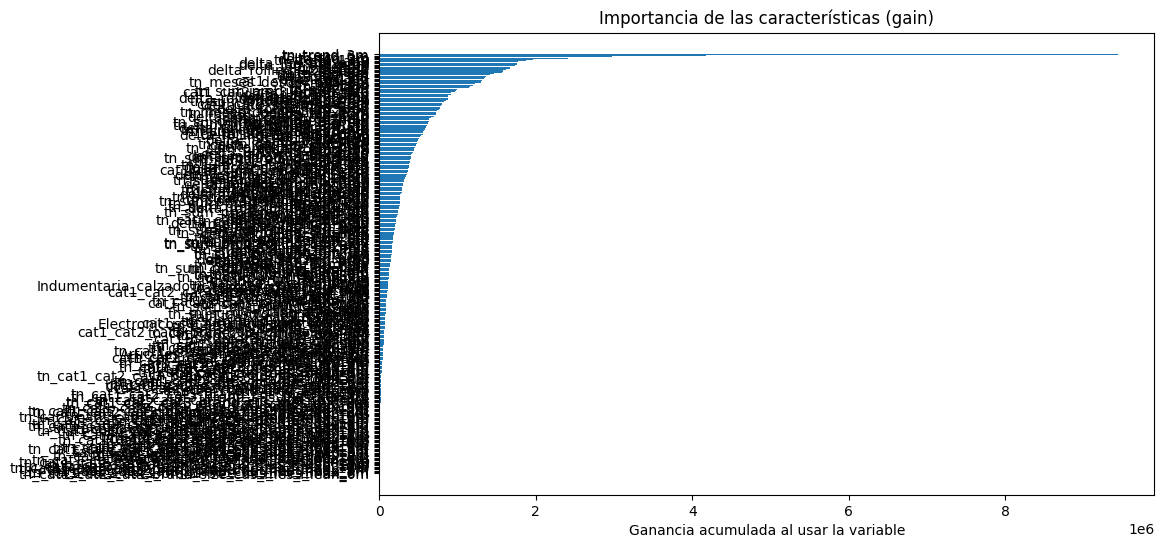

In [24]:
plt.figure(figsize=(10,6))
plt.barh(df_importances['feature'], df_importances['importance_gain'])
plt.xlabel('Ganancia acumulada al usar la variable')
plt.title('Importancia de las características (gain)')
plt.gca().invert_yaxis()
plt.show()

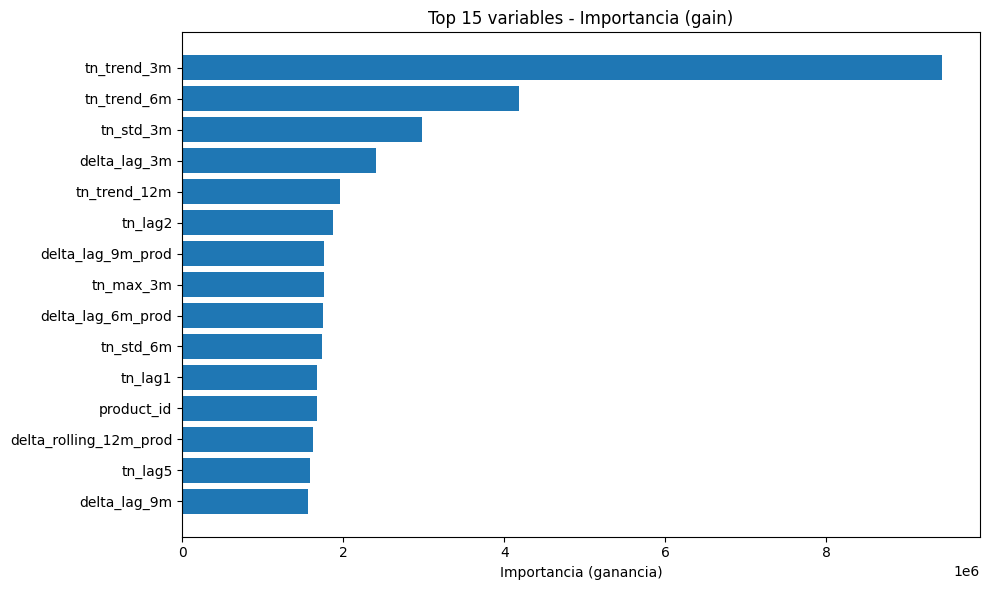

In [25]:
top = df_importances.sort_values('importance_gain', ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top['feature'][::-1], top['importance_gain'][::-1])  # Invierte para mayor arriba
plt.xlabel('Importancia (ganancia)')
plt.title('Top 15 variables - Importancia (gain)')
plt.tight_layout()
plt.show()

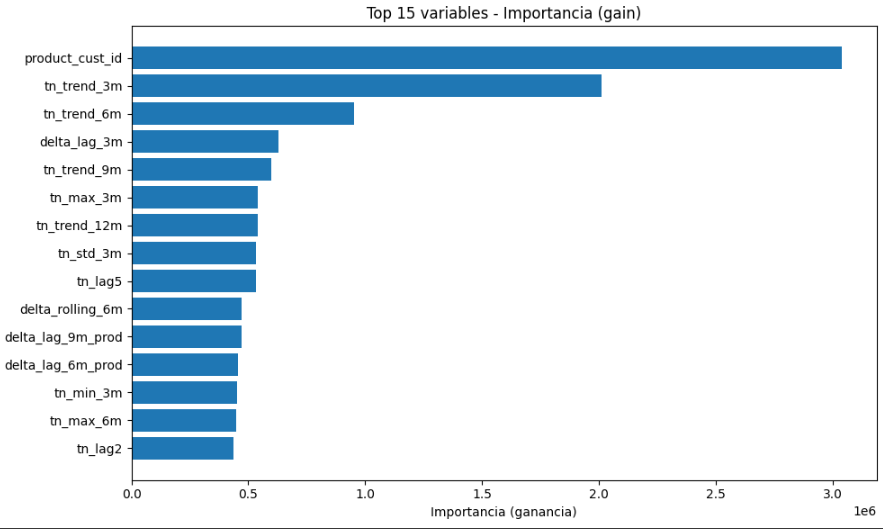

In [26]:
df_36 = df_cluster_X[df_cluster_X['date_mes'] == '2019-12'].copy()

# Escalar solo num_cols
for col in num_cols:
    tipo, val = scalers[col]
    if tipo == 'std':
        df_36[col] = df_36[col] / val
    elif tipo == 'mean':
        df_36[col] = df_36[col] / val
    # else: no escala

In [27]:
# Label encoding para categóricas (manejar categorías nuevas con cuidado)
for col in categorical_cols:
    le = le_dict[col]
    vals = df_36[col].astype(str).fillna('missing')
    # Si aparecen categorías nuevas, las convertimos a -1 para evitar error
    df_36[col] = vals.map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

X_36 = df_36[num_cols + categorical_cols]

In [28]:
X_36.shape

(6258, 326)

In [29]:
# Predecimos la diferencia tn_38 - tn_36
pred_diff = gbm_final.predict(X_36)

# Reconstruimos la predicción absoluta para mes 38
df_36['tn_pred_38'] = df_36['tn'] + pred_diff

# Mostrar resultados
print(df_36[['product_cust_id', 'tn', 'tn_pred_38']].head())

       product_cust_id       tn  tn_pred_38
17144      20001_10003  102.275     109.158
39522      20001_10007  109.557     178.390
60839      20001_10013  243.982     171.152
100410     20001_10040    1.848       0.332
108420     20001_10053    0.000      -0.402


/tmp/ipython-input-29-1009334013.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_36['tn_pred_38'] = df_36['tn'] + pred_diff


In [30]:
df_result = df_36[['product_cust_id', 'tn_pred_38']].copy()
df_result.head()

,product_cust_id,tn_pred_38
17144,20001_10003,109.158
39522,20001_10007,178.390
60839,20001_10013,171.152
100410,20001_10040,0.332
108420,20001_10053,-0.402


In [31]:
df_historia.head()

,product_cust_id,min
0,20001_10003,1.848
1,20001_10007,28.934
2,20001_10013,16.019
3,20001_10040,0.123
4,20001_10053,0.056


In [40]:
df_37= df_36.copy()
df_37.shape

(6258, 338)

In [43]:
SEEDS = [17,53,101,199,281,397,503,619,733,853,967,1087,1223,1361,1489]
#SEEDS = [17]

for current_seed in SEEDS:
    final_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': current_seed,
    })

    lgb_full = lgb.Dataset(X, label=y, categorical_feature=categorical_cols)
    gbm_final = lgb.train(
        final_params,
        lgb_full,
        num_boost_round=1000,
        #verbose_eval=100
    )
    # Predecimos la diferencia tn_38 - tn_36
    pred_diff = gbm_final.predict(X_36)
    df_temp = pd.DataFrame()
    seed_str=str(current_seed)
    df_37['tn_seed_'+ seed_str] = df_36['tn'] + pred_diff


print(df_37.shape)

(6258, 353)


In [44]:
df_result_seeds = df_37[['product_cust_id', 'tn_pred_38','tn_seed_17','tn_seed_53','tn_seed_101','tn_seed_199','tn_seed_281','tn_seed_397','tn_seed_503','tn_seed_619','tn_seed_733','tn_seed_853','tn_seed_967','tn_seed_1087','tn_seed_1223','tn_seed_1361','tn_seed_1489']].copy()
df_result_seeds.head()

,product_cust_id,tn_pred_38,tn_seed_17,tn_seed_53,tn_seed_101,tn_seed_199,tn_seed_281,tn_seed_397,tn_seed_503,tn_seed_619,tn_seed_733,tn_seed_853,tn_seed_967,tn_seed_1087,tn_seed_1223,tn_seed_1361,tn_seed_1489
17144,20001_10003,109.158,107.613,92.731,100.197,105.581,106.434,108.055,105.264,98.985,106.484,111.006,104.468,98.379,108.529,106.367,92.196
39522,20001_10007,178.390,168.301,159.780,169.478,173.342,173.673,170.665,170.292,167.270,176.613,171.125,162.933,167.814,177.548,177.263,168.084
60839,20001_10013,171.152,176.896,167.718,175.677,177.629,178.783,169.710,183.521,171.952,174.042,172.510,172.483,168.224,180.097,168.842,177.986
100410,20001_10040,0.332,0.271,0.169,0.442,0.335,0.271,-0.556,-0.337,-0.387,0.801,-0.390,-0.014,0.360,0.078,0.318,-0.109
108420,20001_10053,-0.402,0.316,0.022,-0.605,0.381,0.560,-0.130,0.394,-0.315,-0.066,-0.172,-0.554,-0.111,0.026,-0.221,-1.534


In [45]:
# 1. Detectar la(s) columna(s) tipo string (object); asumir que solo hay una
str_cols = df_result_seeds.select_dtypes(include='object').columns.tolist()  # Ej: ['nombre']

# 2. Detectar las columnas numéricas
num_cols = df_result_seeds.select_dtypes(include='number').columns.tolist()  # Ej: ['valor1', 'valor2', 'valor3']

# 3. Calcular el promedio de las columnas numéricas por fila y crear la columna 'tn'
df_result_seeds['tn'] = df_result_seeds[num_cols].mean(axis=1)

# 4. Dejar solo la columna string y la columna 'tn'
df_sem = df_result_seeds[str_cols + ['tn']]

# Ahora tu DataFrame se ve así:
#   nombre   tn
# 0    Ana  4.0
# 1   Luis  5.0
# 2    Eva  6.0

# Opcional: imprime el resultado
print(df_sem.head())

       product_cust_id       tn
17144      20001_10003  103.840
39522      20001_10007  170.786
60839      20001_10013  174.201
100410     20001_10040    0.099
108420     20001_10053   -0.151


In [46]:
# es muy raro que el mismo comprador compre menos de lo que ha comprado, y mucho menos puede comprar negativo
# Unimos ambos DataFrames usando product_cust_id como llave
df_result_1 = pd.merge(df_sem, df_historia[['product_cust_id', 'min']], on='product_cust_id', how='inner')

# Definimos la función para calcular el forecast según las reglas dadas
def calcular_forecast(row):
    tn_pred = row['tn']
    min_val = row['min']
    if tn_pred > min_val:
        return tn_pred
    elif tn_pred > (min_val / 2) and tn_pred <= min_val:
        return min_val
    else:
        return 0

# Aplicamos la función para calcular la nueva columna 'forecast'
df_result_1['forecast'] = df_result_1.apply(calcular_forecast, axis=1)

# Si solo quieres quedarte con product_cust_id y forecast:
df_result_1 = df_result_1[['product_cust_id', 'forecast']]

In [47]:
df_result_1.head()

,product_cust_id,forecast
0,20001_10003,103.840
1,20001_10007,170.786
2,20001_10013,174.201
3,20001_10040,0.123
4,20001_10053,0.000


In [48]:
# Crear nueva columna 'product_id' tomando los primeros 5 caracteres de 'product_cust_id'
df_result_1['product_id'] = df_result_1['product_cust_id'].str[:5]

# Agrupar por 'product_id' y sumarizar la columna 'forecast' en una nueva columna 'forecast_plus'
df_summary = df_result_1.groupby('product_id', as_index=False)['forecast'].sum()

# Renombrar la columna resultante para que se llame 'forecast_plus'
df_summary = df_summary.rename(columns={'forecast': 'forecast_plus'})

# Mostrar el resultado
print(df_summary.head())

  product_id  forecast_plus
0      20001        453.150
1      20002        260.563
2      20003        322.442
3      20004        106.953
4      20005        155.693


In [49]:
df_summary['product_id']=df_summary['product_id'].astype(int)

In [50]:
# Merge para obtener el promedio solo para los product_id que están en productos_validar
df_validar = productos_validar.merge(
    df_summary,
    on='product_id',
    how='left'
)

# Ahora df_validar_promedio tendrá dos columnas: product_id y tn_prom_2018
print(df_validar.head())

   product_id  forecast_plus
0       20001        453.150
1       20002        260.563
2       20003        322.442
3       20004        106.953
4       20005        155.693


In [51]:
# le cambio el nombre de mean a tn
df_validar.rename(columns={'forecast_plus': 'tn'}, inplace=True)
df_validar.head()

,product_id,tn
0,20001,453.150
1,20002,260.563
2,20003,322.442
3,20004,106.953
4,20005,155.693


In [52]:
df_validar.to_csv(DATOS_DIR +'df_cluster3_lgbm_V3.csv', index=False)